In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:

# General libraries
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, LeakyReLU, Activation, Lambda, GlobalAveragePooling2D, DepthwiseConv2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf

# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
input_path = '/content/drive/My Drive/four_class/Fold 5/' #Change it as necessary, This is the base path for data

In [ ]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=10,
                                       featurewise_center = True,
                                       featurewise_std_normalization = True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.25,
                                       zoom_range=0.2,
                                       zca_whitening = True,
                                       channel_shift_range=20,
                                       validation_split = 0.2)
    #test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(directory=input_path+'train', target_size=(img_dims, img_dims), batch_size=batch_size, class_mode='categorical',shuffle=True,subset='training')

    val_gen = train_datagen.flow_from_directory(directory=input_path+'train', target_size=(img_dims, img_dims), batch_size=batch_size, class_mode='categorical',shuffle=True,subset='validation')
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    #This code assumes that the name of the folders inside the train folder, test folder and validation folder are named as "PNEUMONIA", "NORMAL" and "COVID19"
    for cond in ['/NORMAL/', '/Bacterial/', '/Viral/','/COVID19/']:#####################
        for img in (os.listdir(input_path + 'test' + cond)):
            img = cv2.imread(input_path+'test'+cond+img, 0) #We are taking image in grayscale form. 
            img = cv2.resize(img, (img_dims, img_dims)) #Resizing to fit the train image size
            img = np.dstack([img, img, img])  #Feinting color image channel
            img = img.astype('float32') / 255.0
            if cond=='/NORMAL/':
                label = 2
            elif cond=='/Bacterial/':
                label = 0
            elif cond=='/Viral/':
                label = 3
            else:
              label = 1 
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    

    
        
    return train_gen,val_gen,test_data, test_labels

In [ ]:
img_dims = 227
epochs =50
batch_size = 16

# Getting the data
train_gen,val_gen,test_data, test_labels = process_data(img_dims, batch_size)
test_data.shape

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 1048 images belonging to 4 classes.
Found 260 images belonging to 4 classes.


(324, 227, 227, 3)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test_cat = to_categorical(test_labels)

print(y_test_cat.shape)

(324, 4)


In [ ]:
##########MODEL DESCRIPTION GOES HERE ###############
########### THIS IS AlexNet ########## 

num_classes=4

IMAGE_SIZE = [227,227]
inceptionv3 = tf.keras.applications.DenseNet121(input_shape = IMAGE_SIZE + [3], weights = 'imagenet',include_top = False,pooling='avg')


for layer in inceptionv3.layers[:]:
    layer.trainable = True

#x = GlobalAveragePooling2D(inceptionv3.output)
#x = Flatten()(inceptionv3.output)
x=Dense(256,activation='relu')(inceptionv3.output)
x=Dense(128,activation='relu')(x)
x=Dropout(.2)(x)
#x=Dense(256,activation='relu')(x)
prediction = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inceptionv3.input,outputs=prediction)





opt = Adam(lr=0.0001)# Make sure to change the learing rate when training for unfreeze
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


29089792/29084464 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 233, 233, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 114, 114, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 114, 114, 64) 256         conv1/conv[0][0]                 
______________________

In [ ]:
model_name = '4 class densenet121 fold 5'#########################################################################

weight_save_path = '/content/drive/My Drive/Results/Weight/'

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose=2, mode='max', min_lr=0.000001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, mode='min')
checkpoint = ModelCheckpoint(weight_save_path+model_name+'.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

In [ ]:
# Fitting the model 
hist = model.fit(train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=val_gen, 
           validation_steps=val_gen.samples // batch_size, callbacks=[lr_reduce, checkpoint])


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
65/65 [==============================] - 314s 5s/step - loss: 0.7515 - accuracy: 0.7103 - val_loss: 1.0803 - val_accuracy: 0.4648
Epoch 2/50
65/65 [==============================] - 40s 610ms/step - loss: 0.4115 - accuracy: 0.8508 - val_loss: 1.2270 - val_accuracy: 0.4609
Epoch 3/50
65/65 [==============================] - 40s 621ms/step - loss: 0.3871 - accuracy: 0.8643 - val_loss: 0.8591 - val_accuracy: 0.5547
Epoch 4/50
65/65 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.8973
Epoch 00004: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
65/65 [==============================] - 40s 620ms/step - loss: 0.2912 - accuracy: 0.8973 - val_loss: 0.5047 - val_accuracy: 0.8125
Epoch 5/50
65/65 [==============================] - 39s 604ms/step - loss: 0.2548 - accuracy: 0.9041 - val_loss: 0.7224 - val_accuracy: 0.7188
Epoch 6/50
65/65 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.9351
Epoch 00006: ReduceLROnPlateau

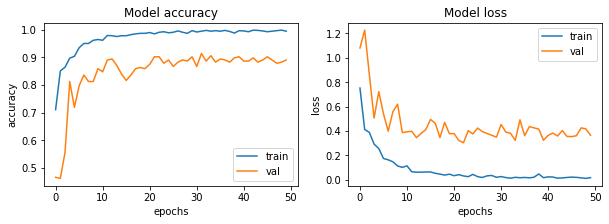

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
model.save_weights(weight_save_path+model_name+'.h5')

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_data)
y_pred_bool = np.argmax(y_pred, axis=1)

report = classification_report(test_labels, y_pred_bool, output_dict=True)
print(classification_report(test_labels, y_pred_bool))

              precision    recall  f1-score   support

           0       0.87      0.73      0.79        81
           1       1.00      0.99      0.99        81
           2       0.77      0.98      0.86        81
           3       0.75      0.68      0.71        81

    accuracy                           0.84       324
   macro avg       0.85      0.84      0.84       324
weighted avg       0.85      0.84      0.84       324



In [ ]:

from tensorflow.keras.utils import plot_model

############## Make Sure to Change this ####################
plot_save_path = '/content/drive/My Drive/Results/ModelPlot/'
hist_save_path = '/content/drive/My Drive/Results/History/'
result_save_path = '/content/drive/My Drive/Results/Result/'
confusion_matrix_save_path = '/content/drive/My Drive/Results/Confusion Matrix/'


hist_df = pd.DataFrame(hist.history)
hist_csv_file = hist_save_path+model_name+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

plot_model(model, plot_save_path+model_name+'.png', show_shapes=True)

result_df = report
result_df = pd.DataFrame(result_df).transpose()

print(result_df)

result_df.to_csv(result_save_path+model_name+'_result.csv')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.685918 to fit

              precision    recall  f1-score     support
0              0.867647  0.728395  0.791946   81.000000
1              1.000000  0.987654  0.993789   81.000000
2              0.766990  0.975309  0.858696   81.000000
3              0.753425  0.679012  0.714286   81.000000
accuracy       0.842593  0.842593  0.842593    0.842593
macro avg      0.847016  0.842593  0.839679  324.000000
weighted avg   0.847016  0.842593  0.839679  324.000000


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


CONFUSION MATRIX ------------------


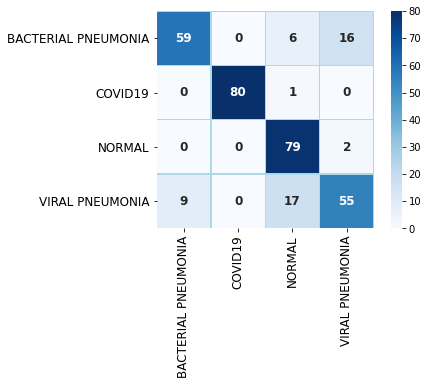

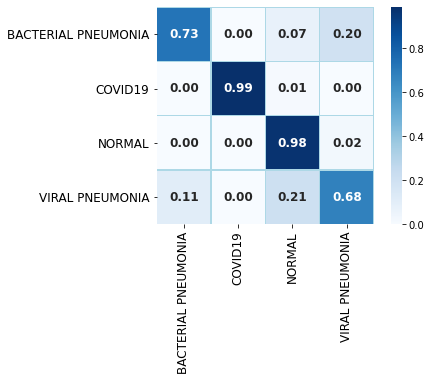

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from seaborn import heatmap
from matplotlib import pyplot as plt

preds = np.argmax(model.predict(test_data), axis=1)
acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
cm_norm = confusion_matrix(test_labels, np.round(preds), normalize='true')
#tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')

ax = heatmap(cm, cmap='Blues', linecolor='lightblue',linewidths=.5,annot=True,annot_kws={'size': 12,"weight": "bold"}, xticklabels=['BACTERIAL PNEUMONIA','COVID19', 'NORMAL','VIRAL PNEUMONIA'], yticklabels=['BACTERIAL PNEUMONIA','COVID19', 'NORMAL','VIRAL PNEUMONIA'], square=True, fmt='d')

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12,rotation=0)

plt.savefig(confusion_matrix_save_path+model_name+'.png',dpi=500)
plt.show()

ax = heatmap(cm_norm, cmap='Blues', annot=True,linecolor='lightblue',linewidths=.5,annot_kws={'size': 12,"weight": "bold"}, xticklabels=['BACTERIAL PNEUMONIA','COVID19', 'NORMAL','VIRAL PNEUMONIA'], yticklabels=['BACTERIAL PNEUMONIA','COVID19', 'NORMAL','VIRAL PNEUMONIA'], square=True, fmt='.2f')

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12,rotation=0)

plt.savefig(confusion_matrix_save_path+model_name+'_normalized.png',dpi=500)